## 5. K-nearest neighbours

### Set up the session

#### Import libraries

In [1]:
import os #using operating system dependent functionality.
import numpy as np #Computations
import pandas as pd #For data manipulation
import pickle # for serializing and de-serializing a Python object structure
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler # to standardize features 

import matplotlib.pyplot as plt #for plotting
%matplotlib inline 

#### Set directories

In [2]:
print(os.getcwd())
dirRawData = "../RawData/"
dirPData = "../PData/"
dirPOutput = "../POutput/"

C:\Users\rodo2\Dropbox\aml\projects\CW\Part2\PCode


#### Load the data

In [3]:
# load df_all
f_name = dirPData + '02_df.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
df_all_onehot = dict_['df_all_onehot']

del f_name, dict_

In [4]:
# load the dict_ that was saved to pickle
#dict_ = {'vars_ind': vars_ind, 'idx_design': idx_design, 'idx_test': idx_test}
f_name = dirPData + '02_vars.pickle'
with open(f_name, "rb") as f:
    dict_ = pickle.load(f)
    
var_dep = dict_['var_dep']
vars_ind_num = dict_['vars_ind_num']
vars_ind_categorical = dict_['vars_ind_categorical']
vars_ind_onehot = dict_['vars_ind_onehot']

del f_name, dict_

#### Preparing the data

In [5]:
#Create indexes for the train, validatiom, design and test set
idx_train  = np.where(df_all_onehot['fold'].isin(np.arange(0,8)))[0] 
idx_val    = np.where(df_all_onehot['fold'].isin([8,9]))[0]
idx_design = np.where(df_all_onehot['fold'].isin(np.arange(0,10)))[0]
idx_test   = np.where(df_all_onehot['fold'].isin([10]))[0]

In [6]:
#Check if the validation set and the train set is the same as the design set
len(idx_val)+len(idx_train) == len(idx_design)

True

In [7]:
#Store the length of the indexes 
n_train = len(idx_train)
n_val = len(idx_val)
n_test = len(idx_test)

In [8]:
#store all the independent variables into one
vars_ind = vars_ind_num + vars_ind_onehot

In [9]:
X = df_all_onehot[vars_ind].values #extract the values

# Standardise (each feature to have mean:0 and stdev:1)
X_train  = X[idx_train, :]

standardScaler_ = StandardScaler()
standardScaler_.fit(X_train)

# Now standardise all the data
X = standardScaler_.transform(X)

In [10]:
X_design = X[idx_design, :]
X_train  = X[idx_train, :]
X_val    = X[idx_val, :]
X_test   = X[idx_test, :]

In [11]:
y_design = df_all_onehot[var_dep].iloc[idx_design].copy().values.ravel()
y_train  = df_all_onehot[var_dep].iloc[idx_train].copy().values.ravel()
y_val    = df_all_onehot[var_dep].iloc[idx_val].copy().values.ravel()
y_test   = df_all_onehot[var_dep].iloc[idx_test].copy().values.ravel()

## k-nearest neighbours

#### Import libraries

In [12]:
from sklearn.neighbors import KNeighborsClassifier

#### Tunning k parameter 

In [13]:
#set a range for k parameter
k_range = range(1, 15) 
#variable to store the mean absolute error for each k
auc_k = np.zeros(len(k_range)) #initialisation with 0s
for k in k_range:
    sknn_ = KNeighborsClassifier(n_neighbors=k, 
                                weights='uniform',
                                algorithm='auto', 
                                p=2, 
                                metric='minkowski')
    sknn_.fit(X_train, y_train) 
    sknn_pred_val = sknn_.predict(X_val)
    auc_k[k - 1] = roc_auc_score(y_val,sknn_pred_val)

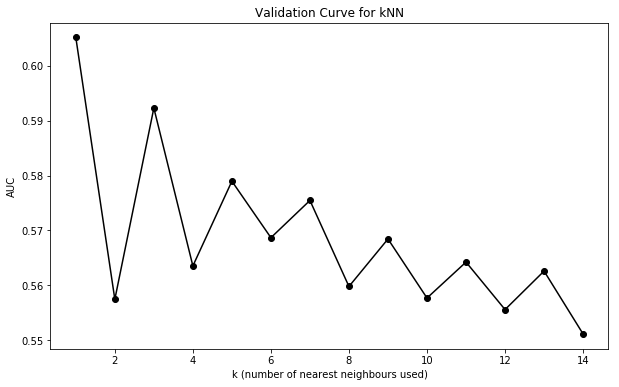

In [26]:
#Plotting the validation curve to see the best k
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(1, 1, 1)

ax1.plot(k_range, auc_k, 'ko-')
ax1.set_xlabel('k (number of nearest neighbours used)')
ax1.set_ylabel('AUC')
_ = plt.title('Validation Curve for kNN')

In [39]:
#Find the k with the minimum MAE
best_k = 3

In [40]:
auc_k

array([0.60512599, 0.55747511, 0.5922859 , 0.56355053, 0.57897065,
       0.56869093, 0.57546653, 0.55981265, 0.56845718, 0.55770995,
       0.56425179, 0.55560726, 0.5626166 , 0.55116812])

#### Modelling

In [41]:
#Fit the model on design set
sknn_ = KNeighborsClassifier(n_neighbors=best_k, 
                            weights='uniform',
                            algorithm='auto', 
                            p=2, 
                            metric='minkowski')
sknn_.fit(X_design, y_design)
#Predict on design set
sknn_pred_design_prob = sknn_.predict_proba(X_design) #probability estimates for the test data X_test


#Predict on test set
sknn_pred_test = sknn_.predict(X_test) #predicted values
sknn_pred_test_prob = sknn_.predict_proba(X_test) #probability estimates for the test data X_test

#### Performance

In [42]:
#kfold cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False)

from sklearn.model_selection import cross_val_score
result_roc_auc = cross_val_score(sknn_, X_design, np.ravel(y_design), cv=kf, scoring='roc_auc')
result_accuracy = cross_val_score(sknn_, X_design, np.ravel(y_design), cv=kf, scoring='accuracy')
print("average score using 10 fold cross validation on design data: {}".format(result_accuracy.mean()))
print("average roc_auc score using 10 fold cross validation on design data: {}".format(result_roc_auc.mean()))

average score using 10 fold cross validation on design data: 0.9066218360840785
average roc_auc score using 10 fold cross validation on design data: 0.6340344940299012


In [43]:
#Calculate the mean accuracy on the given data and labels from design set
score_des = sknn_.score(X_design, y_design) 
#Calculate the mean accuracy on the given data and labels from validation set
score_val = sknn_.score(X_val, y_val) 

In [44]:
score_des

0.9340411302457783

In [45]:
score_val

0.9388015299617509

## Save the model

In [46]:
f_name = dirPData + 'kNN_model.pickle'

with open(f_name, "wb") as f:
    pickle.dump(sknn_, f)
    
f_name

'../PData/kNN_model.pickle'

## Save predictions 

In [47]:
import csv
f_name = dirPOutput + 'knn_predictions.csv'
df_test = pd.read_csv(dirRawData + 'test.csv')

with open(f_name, 'w') as csvfile:
    writer=csv.writer(csvfile, delimiter=',')
    writer.writerow(["id", "target"])
    writer.writerows(zip(df_test[df_test.columns[0]], sknn_pred_test_prob[:,1]))

In [48]:
#save data
dict_ = {'knn_prob_design': sknn_pred_design_prob,
        'knn_prob_test' : sknn_pred_test_prob}

f_name = dirPData + 'knn.pickle'
with open(f_name, "wb") as f:
    pickle.dump(dict_, f)
del f_name

Kaggle score for kNN: 0.67657 

Note: This score is before we made some changes. We weren't able to update our predictions on Kaggle, but we don't expect the score to be much different.